In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

### Se importan los datos del csv para comenzar el análisis

In [163]:
def carga_datos_csv(path, archivo, separador = ','):
    '''
    Para cargar los datos desde csv
    Devuelve un dataframe
    '''
    existe = os.path.isfile(path + archivo + '.csv')
    if existe:
        return pd.read_csv(path + archivo + '.csv', sep = separador)
    else:
        raise ValueError('Error, archivo no encontrado')
    


In [164]:
data = carga_datos_csv('data/', 'bank') # Subconjunto de datos para el entrenamiento de los modelos

In [165]:
data_completo = carga_datos_csv('data/', 'bank-full') # Todos los datos

## Análisis de los datos

In [166]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### Información de los datos
Se pueden ver todas las columnas y sus tipos de datos

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


### Se comprueba si existen nulos
Podemos ver que en este caso no hay nulos

In [168]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

### A continuación se analizan los valores de diferentes columnas
Se comienza con la columna 'y', que será la utilizaremos para predecir

In [169]:
data['y'].value_counts() # Se puede ver que la diferencia entre los dos valores es demasiado grande

no     4000
yes     521
Name: y, dtype: int64

### Otras columnas
Posteriormente trataremos algunas de estas columnas

In [170]:
data['month'].value_counts()

may    1398
jul     706
aug     633
jun     531
nov     389
apr     293
feb     222
jan     148
oct      80
sep      52
mar      49
dec      20
Name: month, dtype: int64

In [171]:
data['education'].value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [172]:
data['default'].value_counts() # Otras columnas con 'no' o 'yes'; loan, housing

no     4445
yes      76
Name: default, dtype: int64

In [173]:
data['job'].value_counts()

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

### Vamos a ver la correlación entre las columnas numéricas

In [174]:
data_corr = data.corr()
data_corr

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


Se puede ver en la matrix de correlación que hay bastante valores negativos, al igual que no hay valores cercanos a 0.9


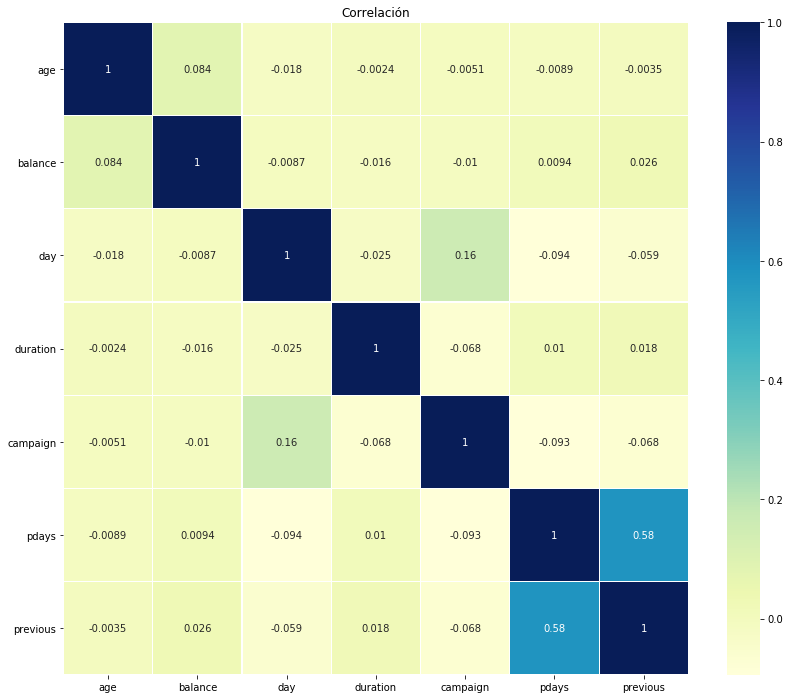

In [175]:
plt.figure(figsize = (14,12))
sns.heatmap(data_corr, linewidths =.2 ,cmap = 'YlGnBu', annot = True)
plt.title('Correlación')
plt.yticks(rotation = 0);

### Ahora vamos a tratar algunas de las columnas categóricas, para que cuando utilizemos dummies no se creen tantas columnas

In [176]:
def meses_to_num(mes):
    '''
    devuelve el número de mes
    '''
    meses = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    num = meses.index(mes) + 1
    return num
    

In [177]:
data['month'] = data['month'].apply(meses_to_num)

In [178]:
columnas_no = ['y', 'loan', 'housing', 'default']
for c in columnas_no:
    data[c] = data[c].apply(lambda  x: 0 if x == 'no' else 1)

In [179]:
data['y'].value_counts() # Se comprueba que este correcto

0    4000
1     521
Name: y, dtype: int64

### Se analiza de nuevo los datos, se puede observar que todavía existen unas cuantas columnas categóricas. Estas se pasarán a numéricas utilizand get_dummies

In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null int64
balance      4521 non-null int64
housing      4521 non-null int64
loan         4521 non-null int64
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null int64
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null int64
dtypes: int64(12), object(5)
memory usage: 600.5+ KB


In [181]:
data_dummies = pd.get_dummies(data, drop_first = True)

In [182]:
data_dummies = data_dummies.dropna()
data_dummies.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,10,79,1,-1,...,1,0,0,0,0,0,0,0,0,1
1,33,0,4789,1,1,11,5,220,1,339,...,1,0,1,0,0,0,0,0,0,0
2,35,0,1350,1,0,16,4,185,1,330,...,0,1,0,1,0,0,0,0,0,0
3,30,0,1476,1,1,3,6,199,4,-1,...,1,0,0,1,0,0,1,0,0,1
4,59,0,0,1,0,5,5,226,1,-1,...,1,0,1,0,0,0,1,0,0,1


In [183]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

## Se van a evaluar los modelos a utilizar

In [184]:
data_evalua = data_dummies.copy()

X = data_evalua.drop(axis = 1, labels = ['y'])
y = data_evalua['y']

In [90]:
def evaluar_metodos(X, y, cv):
    '''
    Se van a evaluar SVC, LogisticRegression y RandomForestClassifier
    Devuelve un diccionario con listas
    0 : Mejor parámetro
    1 : Mejor Score
    2 : Tiempo
    '''
    valores_metodos = {}
    
    parametros = {'SVC' : {'kernel' : ('poly', 'rbf', 'sigmoid'), 
                          'C' : [1, 10]},
                  'LGR' : {'solver' : ('newton-cg', 'liblinear'), 
                          'C' : [1, 10]},
                  'RTF' : {'n_estimators' : [100, 200, 300], 
                         'max_depth' : [2, 4, 8, 10],
                         'random_state' :[2, 4, 8, 10]}
                 }
    
    metodos = {'SVC' : SVC(gamma = 'scale' ),
               'LGR' : LogisticRegression(max_iter = 300),
               'RTF' : RandomForestClassifier()      
              }
    
    for e in metodos:
        clf = GridSearchCV(metodos[e], parametros[e], cv = cv)
        clf.fit(X, y)
        valores_metodos[e] = [clf.best_score_, clf.best_params_, clf.refit_time_]       
   
    return valores_metodos   

In [91]:
valoracion = evaluar_metodos(X, y, 5)

In [185]:
valoracion

{'SVC': [0.8854235788542358, {'C': 10, 'kernel': 'rbf'}, 0.3057541847229004],
 'LGR': [0.9022340190223402,
  {'C': 10, 'solver': 'newton-cg'},
  0.199066162109375],
 'RTF': [0.8967042689670427,
  {'max_depth': 10, 'n_estimators': 200, 'random_state': 8},
  0.4108316898345947]}

### Se escoge el modelo con mejor score

La LogisticRegression es la que nos aparece con mejor score, así que será el método a utilizar

In [186]:
valoracion['LGR'] 

[0.9022340190223402, {'C': 10, 'solver': 'newton-cg'}, 0.199066162109375]

### Se crea las variables de entrenamiento y test

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3616, 32) (905, 32) (3616,) (905,)


In [187]:
#lgr_cls = LogisticRegression(C = 10, solver = 'newton-cg', max_iter = 300)
lgr_cls = OneVsOneClassifier(LogisticRegression(C = 10, solver = 'newton-cg', max_iter = 300)) #Lo tratamos como multiclass

In [188]:
def grafica_roc(fpr, tpr, area):
    '''
    Dibuja Roc Curve
    '''
    plt.figure(figsize = (10,8))
    plt.title('AUC: {:.4f}'.format(area))
    plt.plot([0, 1], [0, 1], color = 'red',  linestyle = '--')
    plt.plot(fpr, tpr, label = 'ROC curve')
    plt.legend()


In [ ]:
def clasificador_single(X_train, X_test, y_train, y_test, cls):
    '''
    calcula ROC curve
    '''
    cls.fit(X_train, y_train)
    clf_predict = cls.predict_proba(X_test)[::,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_predict)
    
    area = metrics.auc(fpr, tpr)
    grafica_roc(fpr, tpr, area)

In [191]:
def clasificador(X_train, X_test, y_train, y_test, cls):
    '''
    calcula ROC curve
    '''
    cls.fit(X_train, y_train)
    clf_predict = cls.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_predict)
    
    area = metrics.auc(fpr, tpr)
    grafica_roc(fpr, tpr, area)

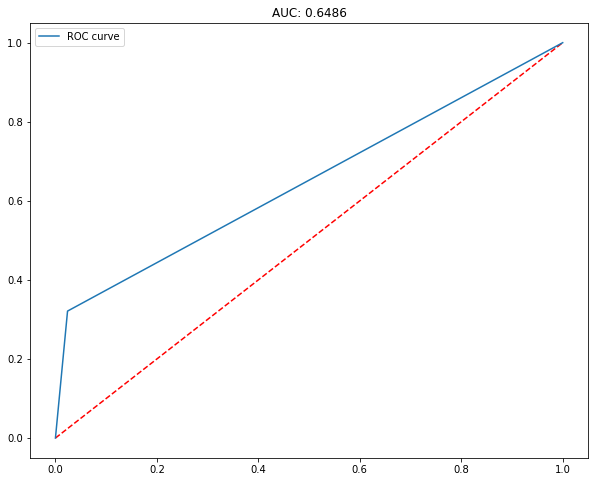

In [192]:
clasificador(X_train, X_test, y_train, y_test, lgr_cls)

### Se calcula la matriz de confución

In [193]:
prediccion = lgr_cls.predict(X_test)
confusion = confusion_matrix(y_test,prediccion)

confusion

array([[777,  19],
       [ 74,  35]])

In [194]:
def dibuja_matriz(matrix, title, columnas, formato):
    '''
    Para dibujar la matriz de confusión
    matrix : matrix de confusión
    title: título para el gráfico
    columnas: nombre para las columnas (lista)
    formato: el formato para mostrar los datos
        1 : .2f
        2 : .2%
        3 : d
    '''
    if formato == 1:
        fmt = '.2f'
    elif formato == 2:
        fmt = '.2%'
    else:
        fmt = 'd'
    
    
    df = pd.DataFrame(matrix, 
                         index = [i for i in columnas],
                         columns = [i for i in columnas])

    plt.figure(figsize = (10,8))
    sns.heatmap(df ,linewidths = .1, cmap = 'YlGnBu', fmt = fmt, annot = True)
    plt.title(title)
    plt.yticks(rotation = 0);

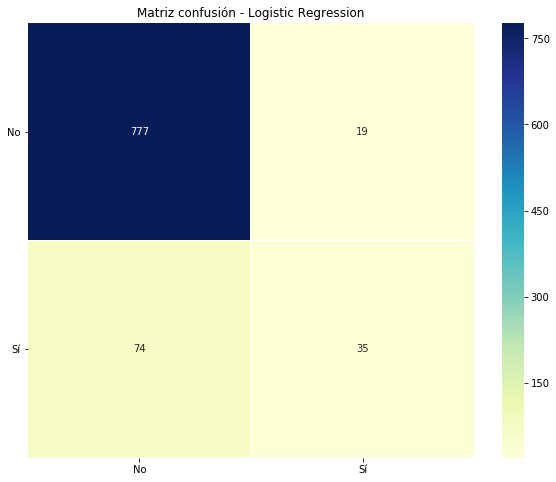

In [195]:
columnas = ['No', 'Sí']
dibuja_matriz(confusion, 'Matriz confusión - Logistic Regression', columnas, 3)

### Vamos a intentar mejorar el modelo
Como en los datos existe Over-sampling, ya que hay pocos valores para 'Sí' y muchos para 'No',
se va a utilizar unas técnicas para intentar mejorar el modelo

In [196]:
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE

In [256]:
def over_sampling(X, y, cls):
    '''
    Prueba algunos metodos para
    corregir el over-sampling
    
    Devuelve un diccionario con los valores
    '''
    sampling = {}
    
    metodos = {'SMOTE' : SMOTE(),
               'ADASYN' : ADASYN(),
               'SVMSMOTE': SVMSMOTE()}
    
    for e in metodos:
        X_resample, y_resample = metodos[e].fit_resample(X, y)
        X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resample,
                                                                    y_resample,
                                                                    test_size = 0.20, 
                                                                    random_state = 10)
        cls.fit(X_train_r, y_train_r)
        clf_predict = cls.predict(X_test_r)
        fpr, tpr, thresholds = metrics.roc_curve(y_test_r, clf_predict)
        area = metrics.auc(fpr, tpr)
        sampling[e] = [area, fpr, tpr]
        
    return sampling

In [257]:
data_evalua = data_dummies.copy()

X = data_evalua.drop(axis = 1, labels = ['y'])
y = data_evalua['y']

In [261]:
metodos_sampling = over_sampling(X, y, lgr_cls)

In [262]:
metodos_sampling

{'SMOTE': [0.9166979362101313,
  array([0.        , 0.05121951, 1.        ]),
  array([0.        , 0.88461538, 1.        ])],
 'ADASYN': [0.9136692115473963,
  array([0.        , 0.06699147, 1.        ]),
  array([0.       , 0.8943299, 1.       ])],
 'SVMSMOTE': [0.9044402751719824,
  array([0.        , 0.07317073, 1.        ]),
  array([0.        , 0.88205128, 1.        ])]}

### Se dibuja la curva para el modelo cuya AUC es mayor

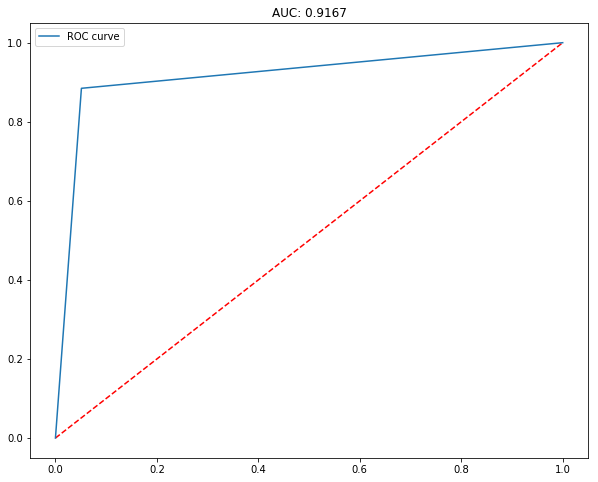

In [263]:
grafica_roc(metodos_sampling['SMOTE'][1], 
            metodos_sampling['SMOTE'][2], 
            metodos_sampling['SMOTE'][0])

### Se va a utilizar SVMSMOTE y Logistic Regression

In [264]:
X_resample, y_resample = SVMSMOTE().fit_resample(X, y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resample,
                                                            y_resample,
                                                            test_size = 0.20, 
                                                            random_state = 10)

In [265]:
lgr_cls_over = LogisticRegression(C = 10, solver = 'newton-cg', max_iter = 300)
lgr_cls_over.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [266]:
y_pred_over = lgr_cls_over.predict(X_test_r)
confusion_over = confusion_matrix(y_test_r, y_pred_over)
confusion_over

array([[810,  10],
       [443, 337]])

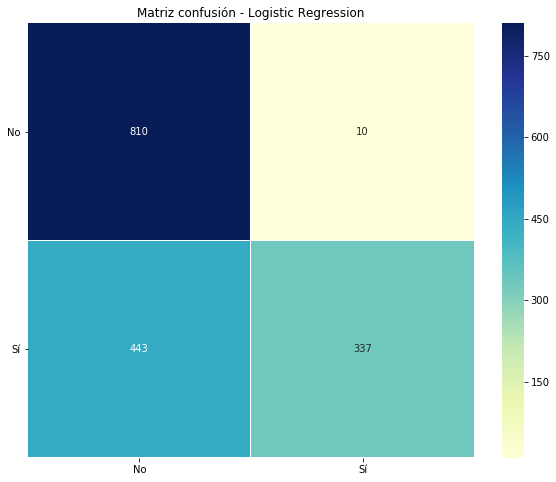

In [267]:
columnas = ['No', 'Sí']
dibuja_matriz(confusion_over, 'Matriz confusión - Logistic Regression', columnas, 3)

### Se realiza una prueba con una fila al azar de todos los datos
Se adecua el dataframe para realizar la prueba

In [268]:
data_pruebas = data_completo.copy()

columnas_no = ['y', 'loan', 'housing', 'default']
for c in columnas_no:
    data_pruebas[c] = data_pruebas[c].apply(lambda  x: 0 if x == 'no' else 1)

In [269]:
data_pruebas['month'] = data_pruebas['month'].apply(meses_to_num)

In [270]:
data_dummies_completo = pd.get_dummies(data_pruebas, drop_first = True)

In [271]:
data_p = data_dummies_completo.sample()
data_p['y'].head()

16739    0
Name: y, dtype: int64

In [272]:
probar = data_p.drop(axis=1, labels=['y'])
resultado_porc = lgr_cls_over.predict_proba(probar)
resultado = lgr_cls_over.predict(probar)
print(resultado_porc)
resultado

[[0.96743784 0.03256216]]


array([0])